In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from scipy.stats import multinomial, beta, dirichlet
from scipy.integrate import cumtrapz
import statsmodels.stats.proportion

# progress bar
from tqdm import tqdm

import pandas as pd

plot_all_lines = False
import warnings
warnings.simplefilter('error', RuntimeWarning)


def beta_std(k, N, alpha=0.32, method='beta'):
    ll, ul = statsmodels.stats.proportion.proportion_confint(k, N, alpha=alpha, method=method)
    return ll, ul, (ul-ll)/2

def pdf_std(pdf, x, alpha=0.32):
    cdf = cumtrapz(pdf,x)/cumtrapz(pdf,x)[-1]
    if len(x[1:][cdf < (0.5-(1-alpha)/2)]) > 0:
        ll = x[1:][cdf < (0.5-(1-alpha)/2)][-1]
    else:
        ll = x[0]
    ul = x[1:][cdf > (0.5+(1-alpha)/2)][0]
    return ll, ul, (ul-ll)/2
    
def make_sample(N, f_M, n, N_M=None, width_I=0.05, width_M=0.05, I=0.6, M=0.8):
    if N_M is None:
        true_gals = np.random.choice([0,1], size=N, p=[1-f_M, f_M])
        true_gals.sort()
    else:
        true_gals = np.array([0]*(N-N_M) + [1]*N_M)
    f_M_sample = true_gals.sum()/N
    N_true = true_gals.sum()
    
    r_Ms = np.random.uniform(low=M-width_M/2, high=M+width_M/2, size=n)
    r_Is = np.random.uniform(low=I-width_I/2, high=I+width_I/2, size=n)

    # Matrix of classifier answers
    m = np.zeros((n, N), dtype='int')
    for i in range(n):
        for j in range(N):
            if true_gals[j] == 0:
                m[i,j] = np.random.choice([0,1], p=[r_Is[i], 1-r_Is[i]])
            elif true_gals[j] == 1:
                m[i,j] = np.random.choice([0,1], p=[1-r_Ms[i], r_Ms[i]])
    N_M = m.sum(axis=1)

    
    return N_true, N_M, r_Ms, r_Is

In [2]:
from scipy.special import binom, loggamma
def logbinom(n, k):
    logbinom = loggamma(n+1) - loggamma(k+1) - loggamma(n-k+1)
    #logbinom[n<k] = -np.inf
    #logbinom[k<0] = -np.inf
    return logbinom

def logbinom_lnnk(n,k):
    logbinom = k*np.log(n/k - 0.5) + k -0.5*np.log(2*np.pi*k)
    return logbinom
    
def f_b(k, n, p, thresh=100):
    # k is an integer, n is an array
    if (p == 0) or (p == 1) or (k < 0):
        return -np.inf
    logf1 = logbinom(n, k)

    logf2 = k*np.log(p)
    logf3 = (n-k)*np.log(1-p)
    logf_b = logf1+logf2+logf3
    #logf_b = logf1
    return logf_b

def L(Ns, rj, rjp, N_M, Ntot, high_acc=False):
    L = 0
    kmin = Ns.min()+N_M-Ntot
    kmax = Ntot
    print(kmin, kmax)
    if high_acc:
        #N_Mks = np.linspace(kmin,kmax,1001)
        N_Mks = np.linspace(0,Ntot,1001)
    else:
        #Ns = Ns.astype(int)
        #N_Mks = np.arange(int(kmin),int(kmax+1))
        N_Mks = np.arange(0.5,Ntot+1)
    for k in N_Mks:
        L1 = np.zeros(len(Ns))-np.inf
        L2 = np.zeros(len(Ns))-np.inf
        inds = ((Ns >= k) & ((Ntot-Ns) >= (N_M-k)))
        L1[inds] = f_b(k, Ns[inds], rj)
        L2[inds] = f_b(N_M-k, Ntot-Ns[inds], 1-rjp)
        L += np.exp(L1+L2)
    return L/sum(L*np.diff(Ns)[0])

def P(N_Mhat, N_M, N_I, r_I, r_M):
    P = 0
    for N_Mhat1 in np.arange(0, N_M+1):
        N_Mhat2 = N_Mhat - N_Mhat1
        P1 = binom(N_M, N_Mhat1)*r_M**N_Mhat1*(1-r_M)**(N_M-N_Mhat1)
        P2 = binom(N_I, N_I-N_Mhat2)*r_I**(N_I-N_Mhat2)*(1-r_I)**N_Mhat2
        P += P1*P2
    return P


def L(N_M, r_I, r_M, N_Mhat, N_tot):
    N_I = N_tot - N_M
    L = np.zeros(len(N_M))
    for i in range(len(L)):
        L[i] = P(N_Mhat, N_M[i], N_I[i], r_I, r_M)
    return L/sum(L*np.diff(N_M)[0])

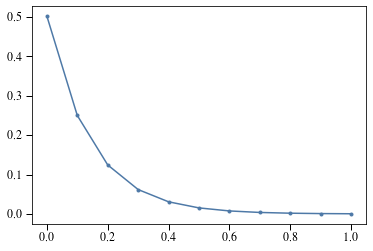

In [3]:
r_M, r_I, N_M = 0.8191511844812219, 0.5923916635105072, 0
N = 10
Ns = np.arange(0, N+1)
f_s = Ns/N
plt.figure()
Ltest = L(Ns, r_M, r_I, N_M, N)
plt.plot(f_s, Ltest, '.-')
Ns = np.arange(N+1)

# A consistency check

Pretend first that there are separate processes, where someone shows you a group of mergers, and another where someone shows you a group of isolated galaxies. Given $N_M$ mergers and an accuracy of measuring $r_M$, the probability that you would say there are $\hat N_{M,1}$  galaxies in this sample is
$$
P(\hat N_{M,1}\mid r_M,N_M)=\binom{N_M}{\hat N_{M,1}}r_M^{\hat N_{M,1}}(1-r_M)^{N_M-\hat N_{M,1}}.
$$
Similarly, if someone showed you $N_I$ mergers and you accurately identified them accurately with a probability $r_I$, you would get $\hat N_{I,1}$ mergers correctly with probability
$$
P(\hat N_{I,1}\mid r_I,N_I)=\binom{N_I}{\hat N_{I,1}}r_I^{\hat N_{I,1}}(1-r_I)^{N_I-\hat N_{I,1}}
$$
However, we're interested in the number of isolated galaxies classified as mergers, $\hat N_{M,2}=N_I-\hat N_{I,1}$. We can write this as
$$
P(\hat N_{M,2}\mid r_I, N_I)=\binom{N_I}{N_I-\hat N_{M,2}}r_I^{N_I-\hat N_{M,2}}(1-r_I)^{\hat N_{M,2}}
$$

Text(0.5, 0, '$\\hat N_{M,2}$')

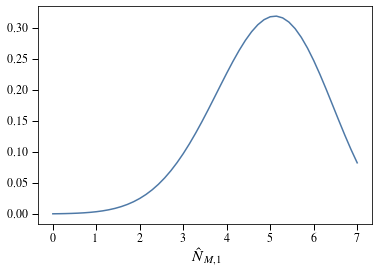

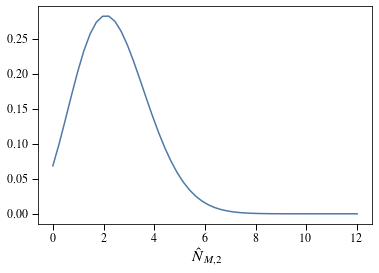

In [4]:
N_M = 7
N_I = 12
N_Mhats1 = np.linspace(0,N_M)
N_Mhats2 = np.linspace(0,N_I)
r_M = 0.7
r_I = 0.8
plt.figure()
plt.plot(N_Mhats1, binom(N_M, N_Mhats1)*r_M**N_Mhats1*(1-r_M)**(N_M-N_Mhats1))
plt.xlabel(r'$\hat N_{M,1}$')

plt.figure()
plt.plot(N_Mhats2, binom(N_I, N_I-N_Mhats2)*r_I**(N_I-N_Mhats2)*(1-r_I)**N_Mhats2)
plt.xlabel(r'$\hat N_{M,2}$')


Now of course, we are interested in the probability that we measure a total of $\hat N_M$ mergers given both of these processes, given a fixed number $N_M$ and $N_I$ of galaxies.

$\hat N_M=\hat N_{M,1}+\hat N_{M,2}$, and these processes happen simultaneously; therefore we want to do the "triangular" sum;

$$
P(\hat N_M\mid r_M,r_I,N_M,N_I)=
\sum_{\hat N_{M,1}+\hat N_{M,2}=\hat N_{M}}
P(\hat N_{M,1}\mid r_M,N_M)P(\hat N_{M,2}\mid r_I,N_I)
$$


Since $\hat N_{M,1}$ is the variable we are more interested in, we will make $\hat N_{M,2}$ a function of it. Also, there are strict limits on $\hat N_{M,1}$, e.g., it cannot be less than 0, or greater than $N_M$. The probability distribution then becomes
$$
P(\hat N_M\mid r_M,r_I,N_M,N_I)=
\sum_{\hat N_{M,1}=0}^{N_M}
P(\hat N_{M,1}\mid r_M,N_M)P(\hat N_M-\hat N_{M,1}\mid r_I,N_I)
$$

12 7
7 7 12
(10000,)


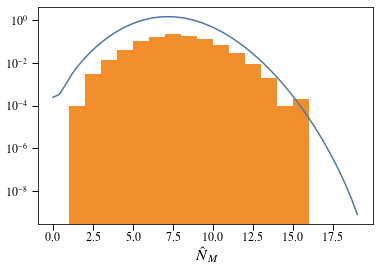

In [15]:
print(N_I, N_M)
N_Mhats = np.linspace(0, N_I+N_M)
        
def P_test(N_Mhats, N_M, N_I, r_I, r_M):
    P = np.zeros_like(N_Mhats)
    for i in range(len(P)):
        for N_Mhat1 in np.linspace(0, N_M):
            N_Mhat2 = N_Mhats[i] - N_Mhat1
            P1 = binom(N_M, N_Mhat1)*r_M**N_Mhat1*(1-r_M)**(N_M-N_Mhat1)
            P2 = binom(N_I, N_I-N_Mhat2)*r_I**(N_I-N_Mhat2)*(1-r_I)**N_Mhat2
            P[i] += P1*P2
    return P
plt.plot(N_Mhats, P_test(N_Mhats,N_M, N_I, r_I, r_M))
plt.xlabel(r'$\hat N_{M}$')


N_true, N_Mhat, r_Ms, r_Is = make_sample(N_I+N_M, N_M/(N_I+N_M), 10000, N_M=N_M, width_I=0.0, width_M=0.0, I=r_I, M=r_M)
plt.hist(N_Mhat, bins = np.arange(N_I+N_M+1), density=True)
print(N_true, N_M, N_I)
print(N_Mhat.shape)
plt.yscale('log')

This curve seems reasonable. Its peak is at the sum of the peak locations for $\hat N_{M,1}$ and $\hat N_{M,2}$.

Now of course, in real life, we would rather have the probability distribution for $N_M$, and we are less interested in $N_I$, but we know that we have $N_\mathrm{tot}$ galaxies, so our probability distribution looks more like (substituting every $N_I\to N_\mathrm{tot}-N_M$)
$$
P(\hat N_M\mid r_M,r_I,N_M,N_\mathrm{tot})=
\sum_{\hat N_{M,1}=0}^{N_M}
P(\hat N_{M,1}\mid r_M,N_M)P(\hat N_M-\hat N_{M,1}\mid r_I,N_\mathrm{tot}-N_M)
$$

To get the posterior distribution, we assume a flat prior on $N_M$, and write
$$
P(N_M\mid\hat N_M,r_M,r_I,N_\mathrm{tot})
\propto P(\hat N_M\mid r_M,r_I,N_M,N_\mathrm{tot})P(N_M)
$$

To evaluate this function, we simply need to take the function above and keep $\hat N_M$ fixed while $N_M$ varies. In practice, we need to be a bit more careful.

$N_M$ can be anywhere from 0 to $N_\mathrm{tot}$. $\hat N_M$ is fixed, but $\hat N_{M,1}$ can vary. The limits of the sum remain the same.

So for each $N_M$, we get one number.

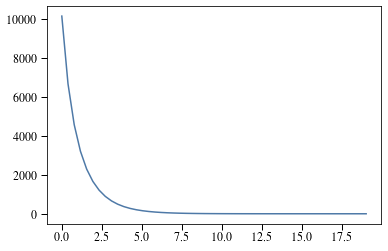

In [6]:
N_tot = 19
N_Ms = np.linspace(0, N_tot)
P_arr = np.zeros_like(N_Ms)
N_Mhat = 7
for i in range(len(N_Ms)):
    for N_Mhat1 in np.linspace(0, N_Ms[i]):
        N_Mhat2 = N_Mhat - N_Mhat1
        P1 = binom(N_Ms[i], N_Mhat1)*r_M**N_Mhat1*(1-r_M)**(N_Ms[i]-N_Mhat)
        P2 = binom(N_tot-N_Ms[i], N_tot-N_Ms[i]-N_Mhat2)*r_I**(N_tot-N_Ms[i]-N_Mhat2)*(1-r_I)**N_Mhat2
        P_arr[i] += P1*P2
plt.plot(N_Ms, P_arr)

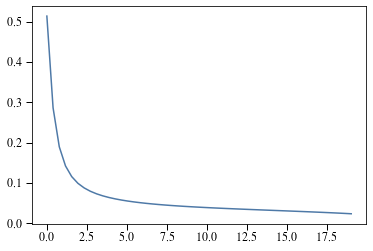

In [7]:
def P_test(N_Mhat, N_Ms, N_tot, r_I, r_M):
    N_Is = N_tot - N_Ms
    P = np.zeros_like(N_Ms)
    for i in range(len(P)):
        for N_Mhat1 in np.linspace(0, N_Ms[i]):
            N_Mhat2 = N_Mhat - N_Mhat1
            P1 = binom(N_Ms[i], N_Mhat1)*r_M**N_Mhat1*(1-r_M)**(N_Ms[i]-N_Mhat)
            P2 = binom(N_Is[i], N_Is[i]-N_Mhat2)*r_I**(N_Is[i]-N_Mhat2)*(1-r_I)**N_Mhat2
            P[i] += P1*P2
    return P


N_Mhat = 7
N_Ms = np.linspace(0, N_M+N_I)
#plt.plot(N_Ms, P(N_Mhat, N_Ms, N_M+N_I, r_I, r_M))

plt.plot(N_Ms, P_test(18, N_Ms, N_M+N_I, r_I, r_M))


As a last test before I take a break, I will write the function such that it only takes scalars as arguments.

64.00000000000003
49.999999999999986


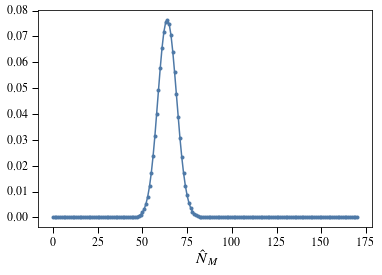

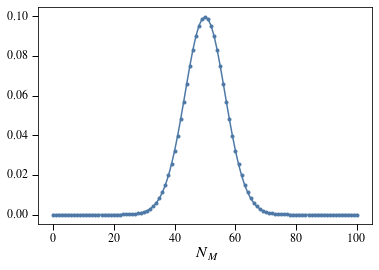

In [8]:
def P_test(N_Mhat, N_M, N_I, r_I, r_M):
    P = 0
    for N_Mhat1 in np.arange(0, N_M+1):
        N_Mhat2 = N_Mhat - N_Mhat1
        P1 = binom(N_M, N_Mhat1)*r_M**N_Mhat1*(1-r_M)**(N_M-N_Mhat1)
        P2 = binom(N_I, N_I-N_Mhat2)*r_I**(N_I-N_Mhat2)*(1-r_I)**N_Mhat2
        P += P1*P2
    return P

N_M = 50
N_I = 120
r_I = 0.8
r_M = 0.8

N_Mhats = np.arange(0, N_M+N_I+1.)
Prob = np.zeros_like(N_Mhats)
for i in range(len(Prob)):
    Prob[i] = P_test(N_Mhats[i], N_M, N_I, r_I, r_M)
plt.plot(N_Mhats, Prob, '.-')
plt.xlabel(r'$\hat N_M$')
print(sum(Prob*N_Mhats)/sum(Prob))

plt.figure()
N_tot = 100

N_Ms = np.arange(0, N_tot+1.)
N_Mhat = 50
Prob = np.zeros_like(N_Ms)
for i in range(len(Prob)):
    Prob[i] = P_test(N_Mhat, N_Ms[i], N_tot-N_Ms[i], r_I, r_M)
plt.plot(N_Ms, Prob, '.-')
plt.xlabel(r'$N_M$')
print(sum(N_Ms*Prob)/sum(Prob))

In [9]:
def P(N_Mhat, N_M, N_I, r_M, r_I):
    Pi = 0
    for N_Mhat1 in np.arange(0, N_M+1):
        N_Mhat2 = N_Mhat - N_Mhat1
        P1 = binom(N_M, N_Mhat1)*r_M**N_Mhat1*(1-r_M)**(N_M-N_Mhat1)
        P2 = binom(N_I, N_I-N_Mhat2)*r_I**(N_I-N_Mhat2)*(1-r_I)**N_Mhat2
        Pi += P1*P2
    return Pi


def L(N_M, r_M, r_I, N_Mhat, N_tot):
    N_I = N_tot - N_M
    Li = np.zeros(len(N_M))
    for i in range(len(N_M)):
        Li[i] = P(N_Mhat, N_M[i], N_I[i], r_M, r_I)
    return Li/sum(Li*np.diff(N_M)[0])

100%|██████████| 5000/5000 [01:19<00:00, 62.74it/s]


Text(0.5, 1.0, 'N=10')

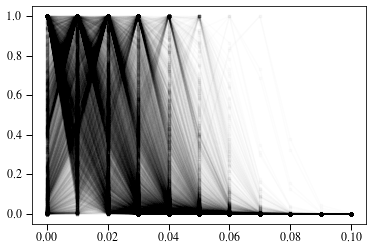

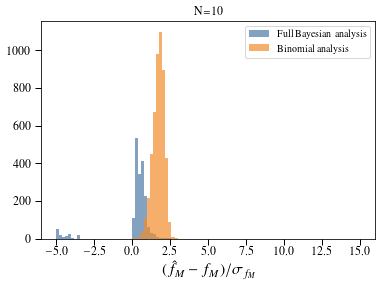

In [12]:
# Total sample size
N = 10
# True merger fraction
f_M = 0.1
# number of classifier
n = 14

n_exp = 5000
mu1 = np.zeros(n_exp)
mu2 = np.zeros(n_exp)
ll1 = np.zeros(n_exp)
ul1 = np.zeros(n_exp)
ll2 = np.zeros(n_exp)
ul2 = np.zeros(n_exp)

N_trues = np.zeros(n_exp)
Z1 = np.zeros(n_exp)
Z2 = np.zeros(n_exp)

Ns = np.arange(0, N+1.)
fs = Ns/N_tot
for _ in tqdm(range(n_exp)):
#for _ in range(n_exp):
    N_true, N_M, r_Ms, r_Is = make_sample(N, f_M, n)
    lnLi = L(Ns, r_Ms[0], r_Is[0], N_M[0], N)*0
    try:
        for i in range(n):
            lnLi += np.log(L(Ns, r_Ms[i], r_Is[i], N_M[i], N))
    except RuntimeWarning:
        print('Runtimewarning')
        break
    Pi = np.exp(lnLi - lnLi.max())
    plt.figure(1)
    plt.plot(fs, Pi, 'k.-', alpha=0.01)
    mu = sum(fs*Pi)/sum(Pi)
    ll, ul, sd = pdf_std(Pi, fs)
    Z1[_] = (mu-N_true/N)/sd
    mu1[_] = mu
    ll1[_] = ll
    ul1[_] = ul
    
    mu = (n*N_M.mean()+1)/(n*N+2)
    mu2[_] = mu
    #ll, ul, sd = beta_std(sum(N_M), n*N)
    ll, ul, sd = beta_std(N_M.mean(), N)
    Z2[_] = (mu-N_true/N)/sd
    ll2[_] = ll
    ul2[_] = ul
    
    N_trues[_] = N_true
bins = np.linspace(-5,15,101)
plt.figure()
plt.hist(Z1, bins=bins, alpha=0.7, label='Full Bayesian analysis')
plt.hist(Z2, bins=bins, alpha=0.7, label='Binomial analysis')
plt.legend(loc='best')
plt.xlabel(r'$(\hat f_M-f_M)/\sigma_{f_M}$')
plt.title(f'N={N}')

100%|██████████| 5000/5000 [14:40<00:00,  5.68it/s]


Text(0.5, 1.0, 'N=50')

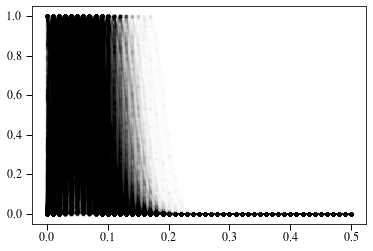

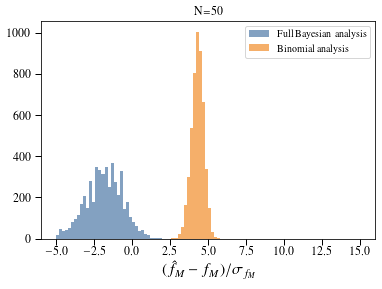

In [13]:
# Total sample size
N = 50
# True merger fraction
f_M = 0.1
# number of classifier
n = 14


n_exp = 5000
mu1 = np.zeros(n_exp)
mu2 = np.zeros(n_exp)
ll1 = np.zeros(n_exp)
ul1 = np.zeros(n_exp)
ll2 = np.zeros(n_exp)
ul2 = np.zeros(n_exp)

N_trues = np.zeros(n_exp)
Z1 = np.zeros(n_exp)
Z2 = np.zeros(n_exp)

Ns = np.arange(0, N+1.)
fs = Ns/N_tot
for _ in tqdm(range(n_exp)):
#for _ in range(n_exp):
    N_true, N_M, r_Ms, r_Is = make_sample(N, f_M, n)
    lnLi = L(Ns, r_Ms[0], r_Is[0], N_M[0], N)*0
    try:
        for i in range(n):
            lnLi += np.log(L(Ns, r_Ms[i], r_Is[i], N_M[i], N))
    except RuntimeWarning:
        print('Runtimewarning')
        break
    Pi = np.exp(lnLi - lnLi.max())
    plt.figure(1)
    plt.plot(fs, Pi, 'k.-', alpha=0.01)
    mu = sum(fs*Pi)/sum(Pi)
    ll, ul, sd = pdf_std(Pi, fs)
    Z1[_] = (mu-N_true/N)/sd
    mu1[_] = mu
    ll1[_] = ll
    ul1[_] = ul
    
    mu = (n*N_M.mean()+1)/(n*N+2)
    mu2[_] = mu
    #ll, ul, sd = beta_std(sum(N_M), n*N)
    ll, ul, sd = beta_std(N_M.mean(), N)
    Z2[_] = (mu-N_true/N)/sd
    ll2[_] = ll
    ul2[_] = ul
    
    N_trues[_] = N_true
bins = np.linspace(-5,15,101)
plt.figure()
plt.hist(Z1, bins=bins, alpha=0.7, label='Full Bayesian analysis')
plt.hist(Z2, bins=bins, alpha=0.7, label='Binomial analysis')
plt.legend(loc='best')
plt.xlabel(r'$(\hat f_M-f_M)/\sigma_{f_M}$')
plt.title(f'N={N}')

100%|██████████| 5000/5000 [52:05<00:00,  1.60it/s]


Text(0.5, 1.0, 'N=100')

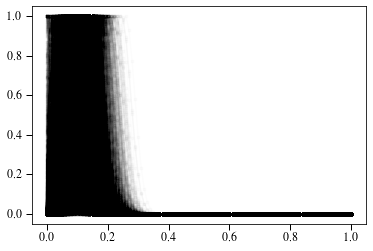

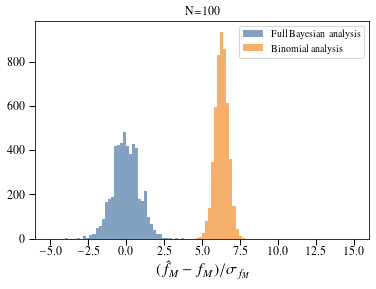

In [14]:
# Total sample size
N = 100
# True merger fraction
f_M = 0.1
# number of classifier
n = 14




n_exp = 5000
mu1 = np.zeros(n_exp)
mu2 = np.zeros(n_exp)
ll1 = np.zeros(n_exp)
ul1 = np.zeros(n_exp)
ll2 = np.zeros(n_exp)
ul2 = np.zeros(n_exp)

N_trues = np.zeros(n_exp)
Z1 = np.zeros(n_exp)
Z2 = np.zeros(n_exp)

Ns = np.arange(0, N+1.)
fs = Ns/N_tot
for _ in tqdm(range(n_exp)):
#for _ in range(n_exp):
    N_true, N_M, r_Ms, r_Is = make_sample(N, f_M, n)
    lnLi = L(Ns, r_Ms[0], r_Is[0], N_M[0], N)*0
    try:
        for i in range(n):
            lnLi += np.log(L(Ns, r_Ms[i], r_Is[i], N_M[i], N))
    except RuntimeWarning:
        print('Runtimewarning')
        break
    Pi = np.exp(lnLi - lnLi.max())
    plt.figure(1)
    plt.plot(fs, Pi, 'k.-', alpha=0.01)
    mu = sum(fs*Pi)/sum(Pi)
    ll, ul, sd = pdf_std(Pi, fs)
    Z1[_] = (mu-N_true/N)/sd
    mu1[_] = mu
    ll1[_] = ll
    ul1[_] = ul
    
    mu = (n*N_M.mean()+1)/(n*N+2)
    mu2[_] = mu
    #ll, ul, sd = beta_std(sum(N_M), n*N)
    ll, ul, sd = beta_std(N_M.mean(), N)
    Z2[_] = (mu-N_true/N)/sd
    ll2[_] = ll
    ul2[_] = ul
    
    N_trues[_] = N_true
bins = np.linspace(-5,15,101)
plt.figure()
plt.hist(Z1, bins=bins, alpha=0.7, label='Full Bayesian analysis')
plt.hist(Z2, bins=bins, alpha=0.7, label='Binomial analysis')
plt.legend(loc='best')
plt.xlabel(r'$(\hat f_M-f_M)/\sigma_{f_M}$')
plt.title(f'N={N}')

In [ ]:
# Make a plot with different merger fractions


f_M_truths = np.arange(0.1, 1, 0.1)
n_exp = 1000
fs = np.linspace(0,1,1001)

Z1mu = []
Z2mu = []
Z1sd = []
Z2sd = []
r_M_base = 0.95
r_I_base = 0.95
fig, axes = plt.subplots(nrows=3, ncols=3, sharex=True, sharey=True)
axs = axes.flatten()
for f_i in range(len(f_M_truths)):
    mu1 = np.zeros(n_exp)
    mu2 = np.zeros(n_exp)
    ll1 = np.zeros(n_exp)
    ul1 = np.zeros(n_exp)
    ll2 = np.zeros(n_exp)
    ul2 = np.zeros(n_exp)

    N_trues = np.zeros(n_exp)
    Z1 = np.zeros(n_exp)
    Z2 = np.zeros(n_exp)

    Ns = N*fs
    for _ in range(n_exp):
        N_true, N_M, r_Ms, r_Is = make_sample(N, f_M_truths[f_i], n, M=r_M_base, I=r_I_base)
        lnLi = L(Ns, r_Ms[0], r_Is[0], N_M[0], N)*0
        for i in range(n):
            lnLi += np.log(L(Ns, r_Ms[i], r_Is[i], N_M[i], N))
        P = np.exp(lnLi - lnLi.max())
        mu = sum(fs*P)/sum(P)
        ll, ul, sd = pdf_std(P, fs)
        Z1[_] = (mu-N_true/N)/sd
        mu1[_] = mu
        ll1[_] = ll
        ul1[_] = ul
    
        mu = (n*N_M.mean()+1)/(n*N+2)
        mu2[_] = mu
        #ll, ul, sd = beta_std(sum(N_M), n*N)
        ll, ul, sd = beta_std(N_M.mean(), N)
        Z2[_] = (mu-N_true/N)/sd
        ll2[_] = ll
        ul2[_] = ul
    
        N_trues[_] = N_true
    if f_i == 0:
        bins = np.linspace(-int(3*Z2.mean()), int(3*Z2.mean()), 101)

    axs[f_i].hist(Z1, bins=bins, alpha=0.5)
    axs[f_i].hist(Z2, bins=bins, alpha=0.5)
    Z1mu.append(Z1.mean())
    Z2mu.append(Z2.mean())
    Z1sd.append(Z2.std())
    Z2sd.append(Z2.std())

# Make plot of merger fraction on horizontal axis, y axis is mean sigma away, error bars are spread of distribution.
plt.figure()
plt.errorbar(f_M_truths, Z1mu, Z1sd, fmt='o')
plt.errorbar(f_M_truths, Z2mu, Z2sd, fmt='o')
plt.xlabel(r'$f_M$')

In [ ]:
# Make a plot with different merger fractions


f_M_truths = np.arange(0.1, 1, 0.1)
fs = np.linspace(0,1,1001)
bins = np.linspace(-10,10, 101)

Z1mu = []
Z2mu = []
Z1sd = []
Z2sd = []
r_M_base = 0.05
r_I_base = 0.05
fig, axes = plt.subplots(nrows=3, ncols=3, sharex=True, sharey=True)
axs = axes.flatten()
for f_i in range(len(f_M_truths)):
    mu1 = np.zeros(n_exp)
    mu2 = np.zeros(n_exp)
    ll1 = np.zeros(n_exp)
    ul1 = np.zeros(n_exp)
    ll2 = np.zeros(n_exp)
    ul2 = np.zeros(n_exp)

    N_trues = np.zeros(n_exp)
    Z1 = np.zeros(n_exp)
    Z2 = np.zeros(n_exp)

    Ns = N*fs
    for _ in range(n_exp):
        N_true, N_M, r_Ms, r_Is = make_sample(N, f_M_truths[f_i], n, M=r_M_base, I=r_I_base)
        lnLi = L(Ns, r_Ms[0], r_Is[0], N_M[0], N)*0
        for i in range(n):
            lnLi += np.log(L(Ns, r_Ms[i], r_Is[i], N_M[i], N))
        P = np.exp(lnLi - lnLi.max())
        mu = sum(fs*P)/sum(P)
        ll, ul, sd = pdf_std(P, fs)
        Z1[_] = (mu-N_true/N)/sd
        mu1[_] = mu
        ll1[_] = ll
        ul1[_] = ul
    
        mu = (n*N_M.mean()+1)/(n*N+2)
        mu2[_] = mu
        #ll, ul, sd = beta_std(sum(N_M), n*N)
        ll, ul, sd = beta_std(N_M.mean(), N)
        Z2[_] = (mu-N_true/N)/sd
        ll2[_] = ll
        ul2[_] = ul
    
        N_trues[_] = N_true
    if f_i == 0:
        bins = np.linspace(-30, 30, 101)

    axs[f_i].hist(Z1, bins=bins, alpha=0.5)
    axs[f_i].hist(Z2, bins=bins, alpha=0.5)
    Z1mu.append(Z1.mean())
    Z2mu.append(Z2.mean())
    Z1sd.append(Z2.std())
    Z2sd.append(Z2.std())

# Make plot of merger fraction on horizontal axis, y axis is mean sigma away, error bars are spread of distribution.
plt.figure()
plt.errorbar(f_M_truths, Z1mu, Z1sd, fmt='o')
plt.errorbar(f_M_truths, Z2mu, Z2sd, fmt='o')
plt.xlabel(r'$f_M$')

In [ ]:
# Make a plot with different merger fractions


f_M_truths = np.arange(0.1, 1, 0.1)
fs = np.linspace(0,1,1001)
bins = np.linspace(-10,10, 101)

Z1mu = []
Z2mu = []
Z1sd = []
Z2sd = []
r_M_base = 0.9
r_I_base = 0.5
fig, axes = plt.subplots(nrows=3, ncols=3, sharex=True, sharey=True)
axs = axes.flatten()
for f_i in range(len(f_M_truths)):
    mu1 = np.zeros(n_exp)
    mu2 = np.zeros(n_exp)
    ll1 = np.zeros(n_exp)
    ul1 = np.zeros(n_exp)
    ll2 = np.zeros(n_exp)
    ul2 = np.zeros(n_exp)

    N_trues = np.zeros(n_exp)
    Z1 = np.zeros(n_exp)
    Z2 = np.zeros(n_exp)

    Ns = N*fs
    for _ in range(n_exp):
        N_true, N_M, r_Ms, r_Is = make_sample(N, f_M_truths[f_i], n, M=r_M_base, I=r_I_base)
        lnLi = L(Ns, r_Ms[0], r_Is[0], N_M[0], N)*0
        for i in range(n):
            lnLi += np.log(L(Ns, r_Ms[i], r_Is[i], N_M[i], N))
        P = np.exp(lnLi - lnLi.max())
        mu = sum(fs*P)/sum(P)
        ll, ul, sd = pdf_std(P, fs)
        Z1[_] = (mu-N_true/N)/sd
        mu1[_] = mu
        ll1[_] = ll
        ul1[_] = ul
    
        mu = (n*N_M.mean()+1)/(n*N+2)
        mu2[_] = mu
        #ll, ul, sd = beta_std(sum(N_M), n*N)
        ll, ul, sd = beta_std(N_M.mean(), N)
        Z2[_] = (mu-N_true/N)/sd
        ll2[_] = ll
        ul2[_] = ul
    
        N_trues[_] = N_true
    if f_i == 0:
        bins = np.linspace(-12, 12, 101)

    axs[f_i].hist(Z1, bins=bins, alpha=0.5)
    axs[f_i].hist(Z2, bins=bins, alpha=0.5)
    Z1mu.append(Z1.mean())
    Z2mu.append(Z2.mean())
    Z1sd.append(Z2.std())
    Z2sd.append(Z2.std())

# Make plot of merger fraction on horizontal axis, y axis is mean sigma away, error bars are spread of distribution.
plt.figure()
plt.errorbar(f_M_truths, Z1mu, Z1sd, fmt='o')
plt.errorbar(f_M_truths, Z2mu, Z2sd, fmt='o')
plt.xlabel(r'$f_M$')

In [ ]:
# Make a plot with different merger fractions


f_M_truths = np.arange(0.1, 1, 0.1)
fs = np.linspace(0,1,1001)
bins = np.linspace(-10,10, 101)

Z1mu = []
Z2mu = []
Z1sd = []
Z2sd = []
r_M_base = 0.5
r_I_base = 0.9
fig, axes = plt.subplots(nrows=3, ncols=3, sharex=True, sharey=True)
axs = axes.flatten()
for f_i in range(len(f_M_truths)):
    mu1 = np.zeros(n_exp)
    mu2 = np.zeros(n_exp)
    ll1 = np.zeros(n_exp)
    ul1 = np.zeros(n_exp)
    ll2 = np.zeros(n_exp)
    ul2 = np.zeros(n_exp)

    N_trues = np.zeros(n_exp)
    Z1 = np.zeros(n_exp)
    Z2 = np.zeros(n_exp)

    Ns = N*fs
    for _ in range(n_exp):
        N_true, N_M, r_Ms, r_Is = make_sample(N, f_M_truths[f_i], n, M=r_M_base, I=r_I_base)
        lnLi = L(Ns, r_Ms[0], r_Is[0], N_M[0], N)*0
        for i in range(n):
            lnLi += np.log(L(Ns, r_Ms[i], r_Is[i], N_M[i], N))
        P = np.exp(lnLi - lnLi.max())
        mu = sum(fs*P)/sum(P)
        ll, ul, sd = pdf_std(P, fs)
        Z1[_] = (mu-N_true/N)/sd
        mu1[_] = mu
        ll1[_] = ll
        ul1[_] = ul
    
        mu = (n*N_M.mean()+1)/(n*N+2)
        mu2[_] = mu
        #ll, ul, sd = beta_std(sum(N_M), n*N)
        ll, ul, sd = beta_std(N_M.mean(), N)
        Z2[_] = (mu-N_true/N)/sd
        ll2[_] = ll
        ul2[_] = ul
    
        N_trues[_] = N_true
    if f_i == 0:
        bins = np.linspace(-12, 12, 101)

    axs[f_i].hist(Z1, bins=bins, alpha=0.5)
    axs[f_i].hist(Z2, bins=bins, alpha=0.5)
    Z1mu.append(Z1.mean())
    Z2mu.append(Z2.mean())
    Z1sd.append(Z2.std())
    Z2sd.append(Z2.std())

# Make plot of merger fraction on horizontal axis, y axis is mean sigma away, error bars are spread of distribution.
plt.figure()
plt.errorbar(f_M_truths, Z1mu, Z1sd, fmt='o')
plt.errorbar(f_M_truths, Z2mu, Z2sd, fmt='o')
plt.xlabel(r'$f_M$')

In [ ]:
%reset -f